# Loan Application Analysis – BPI Challenge 2012

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pm4py
import seaborn as sns

In [17]:
# Preparing data

## Load the event log
from pm4py.objects.log.importer.xes import importer as xes_importer
log = xes_importer.apply("financial_log.xes")

## Convert to DataFrame
from pm4py.objects.conversion.log import converter as log_converter
log_df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

## Convert timestamp column
log_df['time:timestamp'] = pd.to_datetime(log_df['time:timestamp'])

## Basic info
print("Number of events before filtering: {}\nNumber of cases before filtering: {}".format(
    len(log_df), len(log_df['case:concept:name'].unique())))
print("Start activities: {}\nEnd activities: {}".format(
    pm4py.get_start_activities(log_df), pm4py.get_end_activities(log_df)))

parsing log, completed traces :: 100%|██████████| 13087/13087 [00:06<00:00, 2003.53it/s]


Number of events before filtering: 262200
Number of cases before filtering: 13087
Start activities: {'A_SUBMITTED': 13087}
End activities: {'W_Valideren aanvraag': 2747, 'W_Wijzigen contractgegevens': 4, 'A_DECLINED': 3429, 'W_Completeren aanvraag': 1939, 'A_CANCELLED': 655, 'W_Nabellen incomplete dossiers': 452, 'W_Afhandelen leads': 2234, 'W_Nabellen offertes': 1290, 'W_Beoordelen fraude': 57, 'O_CANCELLED': 279, 'A_REGISTERED': 1}


Before filtering:
Min Case Duration: 0 days 00:00:01.855000
Max Case Duration: 137 days 04:18:56.012000
Mean Case Duration: 8 days 14:55:16.341099488

After removing zero-duration cases:
Number of events: 262200
Number of cases: 13087

Min Case Duration: 0 days 00:00:01.855000
Max Case Duration: 137 days 04:18:56.012000
Mean Case Duration: 8 days 14:55:16.341099488

After filtering incomplete cases:
Number of events: 31319
Number of cases: 4084

Min Case Duration: 0 days 00:00:01.855000
Max Case Duration: 91 days 09:55:36.161000
Mean Case Duration: 5 days 02:56:46.771978207


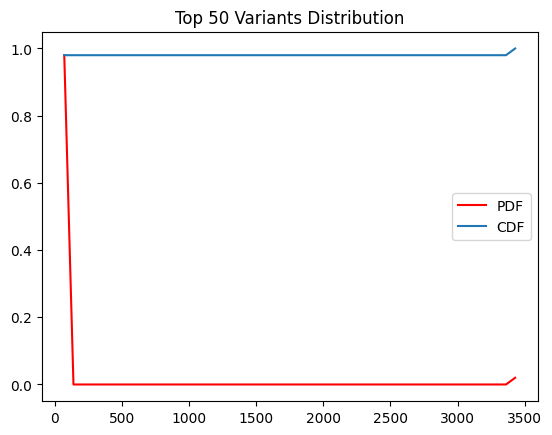


After top-50 variant filtering:
Number of events: 21267
Number of cases: 3838

FINAL FILTERED event log 
Min: 0 days 00:00:01.855000
Max: 33 days 17:12:20.013000
Mean: 3 days 06:01:27.559529703


Final filtered log contains 21267 events and 3838 cases.


Coverage of valid cases: 29.33%


In [18]:
# Filtering the log for noise and incomplete cases

## Activity with null time duration

### Group the event log by case and calculate the basic time metrics
case_durations = log_df.groupby('case:concept:name').agg(   
    Events=('case:concept:name', 'count'),                          # Number of events in each case
    FirstOccurence=('time:timestamp', lambda x: x.min()),           # Start time of the case
    LastOccurence=('time:timestamp', lambda x: x.max()),            # End time of the case
    Duration=('time:timestamp', lambda x: x.max() - x.min()),       # Duration of the case
)

### Get general statistics
min_case_duration = case_durations['Duration'].min()
max_case_duration = case_durations['Duration'].max()
mean_case_duration = case_durations['Duration'].mean()

print("Before filtering:")
print("Min Case Duration: {}\nMax Case Duration: {}\nMean Case Duration: {}".format(
    min_case_duration, max_case_duration, mean_case_duration))

### Identify and remove cases with a duration of zero
zero_duration_cases = case_durations[case_durations['Duration'] == pd.Timedelta(0)].index.tolist()
log_df = log_df[~log_df['case:concept:name'].isin(zero_duration_cases)]

print("\nAfter removing zero-duration cases:")
print("Number of events: {}\nNumber of cases: {}".format(
    len(log_df), len(log_df['case:concept:name'].unique())))

### Duration stats for filtered log
case_durations_z = log_df.groupby('case:concept:name').agg(
    Events=('case:concept:name', 'count'),
    FirstOccurence=('time:timestamp', lambda x: x.min()),
    LastOccurence=('time:timestamp', lambda x: x.max()),
    Duration=('time:timestamp', lambda x: x.max() - x.min()),
)

### Get duration statistics for filtered log
min_case_duration_z = case_durations_z['Duration'].min()
max_case_duration_z = case_durations_z['Duration'].max()
mean_case_duration_z = case_durations_z['Duration'].mean()

print("\nMin Case Duration: {}\nMax Case Duration: {}\nMean Case Duration: {}".format(
    min_case_duration_z, max_case_duration_z, mean_case_duration_z))


## Incomplete cases

### Filter out cases that do not end with a legal end activity
filtered_log = pm4py.filter_end_activities(log_df, [
    'A_APPROVED',
    'A_DECLINED',
    'A_CANCELLED'
])

print("\nAfter filtering incomplete cases:")
print("Number of events: {}\nNumber of cases: {}".format(len(filtered_log), len(filtered_log['case:concept:name'].unique())))


### Duration stats for filtered log
case_durations_f = filtered_log.groupby('case:concept:name').agg(
    Events=('case:concept:name', 'count'),
    FirstOccurence=('time:timestamp', lambda x: x.min()),
    LastOccurence=('time:timestamp', lambda x: x.max()),
    Duration=('time:timestamp', lambda x: x.max() - x.min()),
)

### Get duration statistics for filtered log
min_case_duration_f = case_durations_f['Duration'].min()
max_case_duration_f = case_durations_f['Duration'].max()
mean_case_duration_f = case_durations_f['Duration'].mean()

print("\nMin Case Duration: {}\nMax Case Duration: {}\nMean Case Duration: {}".format(
    min_case_duration_f, max_case_duration_f, mean_case_duration_f))


## Variants analysis

### Get variants and their counts
variants = pm4py.get_variants(filtered_log)
variants_df = pd.DataFrame.from_dict(variants, orient='index', columns=['Count']).reset_index()
variants_df = variants_df.rename(columns={'index': 'Variant'}).sort_values(by='Count', ascending=False).reset_index(drop=True)

### Display top 50 variants
data = variants_df['Count'].head(50)
if len(data) > 0:
    count, bins_count = np.histogram(data, bins=50)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)

    plt.plot(bins_count[1:], pdf, color="red", label="PDF")
    plt.plot(bins_count[1:], cdf, label="CDF")
    plt.title("Top 50 Variants Distribution")
    plt.legend()
    plt.show()
else:
    print("No variants to display.")


### Keep top 50 variants
filtered_log = pm4py.filter_variants_top_k(filtered_log, 50)

num_events = len(filtered_log)
num_cases = len(filtered_log['case:concept:name'].unique())
print("\nAfter top-50 variant filtering:\nNumber of events: {}\nNumber of cases: {}".format(num_events, num_cases))

## Duration stats after final filtering
case_durations_f = filtered_log.groupby('case:concept:name').agg(
    Events=('case:concept:name', 'count'),
    FirstOccurence=('time:timestamp', lambda x: x.min()),
    LastOccurence=('time:timestamp', lambda x: x.max()),
    Duration=('time:timestamp', lambda x: x.max() - x.min()),
)

min_case_duration_f = case_durations_f['Duration'].min()
max_case_duration_f = case_durations_f['Duration'].max()
mean_case_duration_f = case_durations_f['Duration'].mean()

print("\nFINAL FILTERED event log \nMin: {}\nMax: {}\nMean: {}".format(
    min_case_duration_f, max_case_duration_f, mean_case_duration_f))

final_filtered_cases = filtered_log['case:concept:name'].nunique()
print("\n\nFinal filtered log contains {} events and {} cases.".format(
    len(filtered_log), final_filtered_cases))

coverage = final_filtered_cases / len(log_df['case:concept:name'].unique()) * 100
print("\n\nCoverage of valid cases: {:.2f}%".format(coverage))

In [19]:
# Filtering the log for redundant activities

from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

## Discover Directly-Follows Graph (DFG)
dfg = dfg_discovery.apply(filtered_log)

## Get the frequency of each activity and the total number of unique cases
activity_freq = pm4py.get_event_attribute_values(filtered_log, 'concept:name')
case_count = len(filtered_log['case:concept:name'].unique())

## Print activity transitions that occur in every case
print("Directly-Follows Graph (DFG):")
for (act_a, act_b), freq in dfg.items():
    if freq == case_count:
        print(f"{act_a} → {act_b} always follows (frequency = {freq})")

## Identify activity pairs where one activity always follows another
redundant_pairs = [(act_a, act_b) for (act_a, act_b), freq in dfg.items() if freq == case_count]

## Collect the second activity in each redundant pair
redundant_activities = [b for a, b in redundant_pairs]
print("Redundant activities identified:", redundant_activities)

## Remove redundant activities from the log
filtered_log = filtered_log[~filtered_log['concept:name'].isin(redundant_activities)]

print("\nNumber of events: {}\nNumber of cases: {}".format(len(filtered_log), len(filtered_log['case:concept:name'].unique())))


Directly-Follows Graph (DFG):
A_SUBMITTED → A_PARTLYSUBMITTED always follows (frequency = 3838)
Redundant activities identified: ['A_PARTLYSUBMITTED']

Number of events: 17429
Number of cases: 3838


In [23]:
# Segmenting the log based on end activities

## Create a subset of the log for cases that end with A_APPROVED
log_approved = pm4py.filter_end_activities(filtered_log, ['A_APPROVED'])
print("Cases ending with A_APPROVED:", log_approved['case:concept:name'].nunique())

## Create a subset of the log for cases that end with A_DECLINED
log_declined = pm4py.filter_end_activities(filtered_log, ['A_DECLINED'])
print("Cases ending with A_DECLINED:", log_declined['case:concept:name'].nunique())

## Create a subset of the log for cases that end with A_CANCELLED
log_cancelled = pm4py.filter_end_activities(filtered_log, ['A_CANCELLED'])
print("Cases ending with A_CANCELLED:", log_cancelled['case:concept:name'].nunique())

print("\nNumber of events: {}\nNumber of cases: {}".format(len(filtered_log), len(filtered_log['case:concept:name'].unique())))


Cases ending with A_APPROVED: 0
Cases ending with A_DECLINED: 3429
Cases ending with A_CANCELLED: 409

Number of events: 17429
Number of cases: 3838



Case size by Outcome:
           count   mean
outcome                
CANCELLED    409  25.85
DECLINED    3429   2.00

Duration by Outcome:
           count        mean
outcome                     
CANCELLED    409  732.079838
DECLINED    3429    0.010701

Loan amount by Outcome:
           count      mean
outcome                   
CANCELLED    409  13872.39
DECLINED    3429  10868.21

Reworks by Outcome:
           count       mean
outcome                    
CANCELLED    409  20.858191
DECLINED    3429        0.0


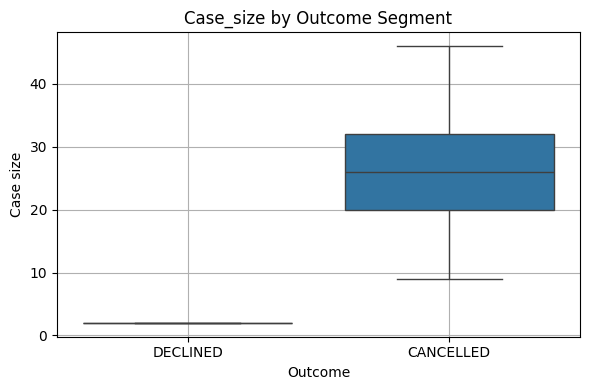

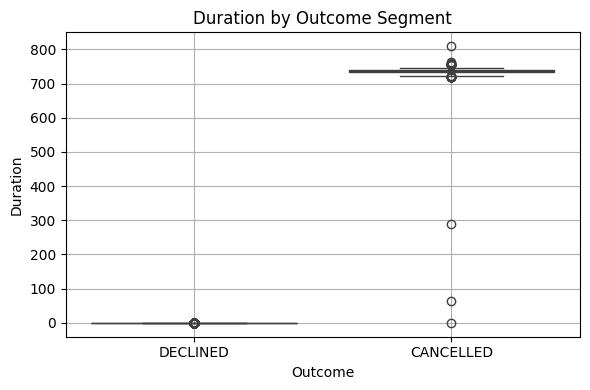

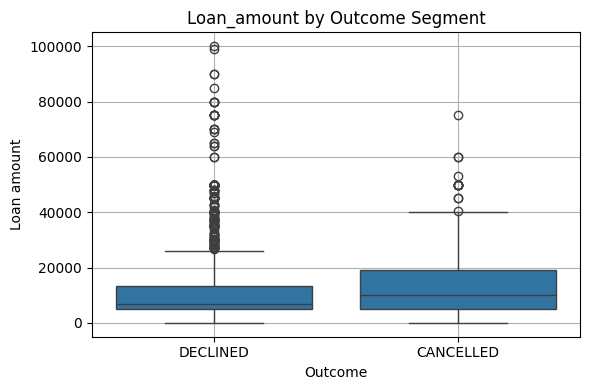

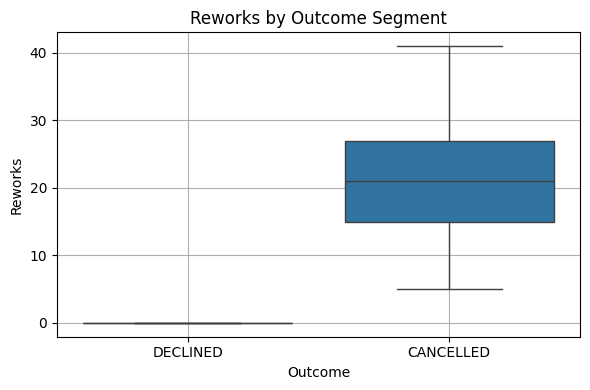

In [24]:
# Comparing segments

## Compute case metrics for each segment
def compute_case_metrics(log, label):
    ### Aggregate per case: number of events, start/end time, duration, and max loan amount
    metrics = log.groupby('case:concept:name').agg(
        case_size=('concept:name', 'count'),
        start_time=('time:timestamp', 'min'),
        end_time=('time:timestamp', 'max'),
        duration=('time:timestamp', lambda x: (x.max() - x.min()).total_seconds() / 3600),
        loan_amount=('case:AMOUNT_REQ', 'max')
    ).reset_index()

    ### Count number of repeated activities per case (rework)
    reworks = log.groupby('case:concept:name')['concept:name'].apply(
        lambda x: x.duplicated().sum()
    ).reset_index(name='reworks')

    result = pd.merge(metrics, reworks, on='case:concept:name')
    
    result['outcome'] = label
    return result

## Compute metrics for each segment
df_approved = compute_case_metrics(log_approved, 'APPROVED')
df_declined = compute_case_metrics(log_declined, 'DECLINED')
df_cancelled = compute_case_metrics(log_cancelled, 'CANCELLED')

## Combine all segment data into a single DataFrame for comparison
combined_df = pd.concat([df_approved, df_declined, df_cancelled])

metrics = ['case_size', 'duration', 'loan_amount', 'reworks']


## Summarize outcome segments for each metric
combined_df['loan_amount'] = pd.to_numeric(combined_df['loan_amount'], errors='coerce')
for metric in metrics:
    print(f"\n{metric.replace('_', ' ').capitalize()} by Outcome:")
    print(combined_df.groupby('outcome')[metric].agg(['count', 'mean']).round(2))

## Visualize each metric across outcome segments using boxplots
metrics = ['case_size', 'duration', 'loan_amount', 'reworks']
for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=combined_df, x='outcome', y=metric)
    plt.title(f"{metric.capitalize()} by Outcome Segment")
    plt.xlabel("Outcome")
    plt.ylabel(metric.replace('_', ' ').capitalize())
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Average duration (days): 3.045823514008903
Median duration (days): 0.0
Average reworks per case: 2.1351139041633935

Outcome Distribution (%):
outcome
A_DECLINED     89.787903
A_CANCELLED    10.212097
Name: proportion, dtype: float64


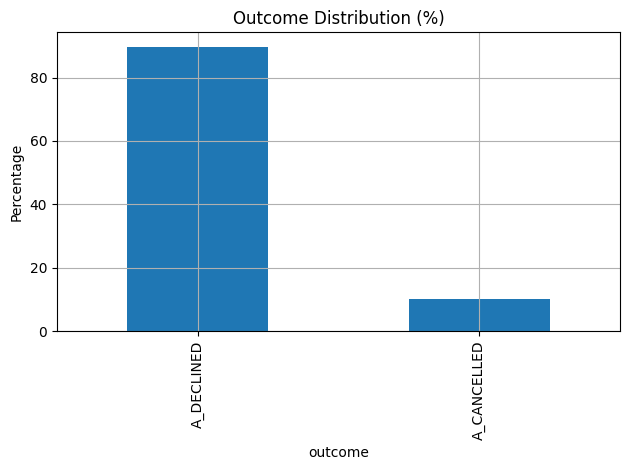

<Figure size 640x480 with 0 Axes>

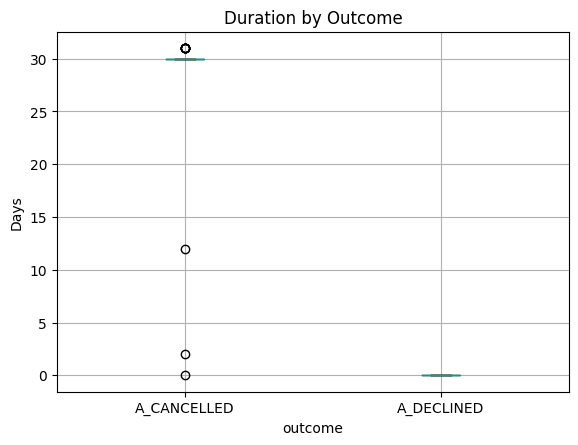

<Figure size 640x480 with 0 Axes>

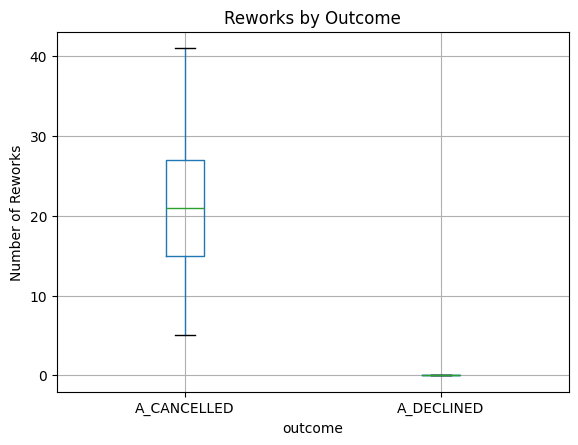

In [22]:
# Analysis of Case Performance by Outcome

## Identify all actual end activities in the filtered log
true_end_activities = list(pm4py.get_end_activities(filtered_log).keys())

## Extract the last event per case based on timestamp
last_events = filtered_log.sort_values('time:timestamp').groupby('case:concept:name').last().reset_index()

## Filter only those cases whose last activity is one of the true end activities
valid_cases = last_events[last_events['concept:name'].isin(true_end_activities)]['case:concept:name']

## Compute basic metrics for each case: size, duration in days, and max requested amount
case_metrics = filtered_log.groupby('case:concept:name').agg(
    case_size=('concept:name', 'count'),
    start_time=('time:timestamp', 'min'),
    end_time=('time:timestamp', 'max'),
    duration_days=('time:timestamp', lambda x: (x.max() - x.min()).days),
    amount=('case:AMOUNT_REQ', 'max')
).reset_index()

## Merge in the outcome label (last activity per case)
case_metrics = case_metrics.merge(
    last_events[['case:concept:name', 'concept:name']],
    on='case:concept:name',
    how='left'
).rename(columns={'concept:name': 'outcome'})

## Keep only valid cases (with proper end activity)
case_metrics = case_metrics[case_metrics['case:concept:name'].isin(valid_cases)]

## Compute the number of repeated activities (reworks) per case
reworks = filtered_log.groupby('case:concept:name')['concept:name'].apply(lambda x: x.duplicated().sum()).reset_index(name='reworks')

## Merge rework counts into the case metrics table
case_metrics = case_metrics.merge(reworks, on='case:concept:name')

## Print average and median case duration, and average rework count
print("Average duration (days):", case_metrics['duration_days'].mean())
print("Median duration (days):", case_metrics['duration_days'].median())
print("Average reworks per case:", case_metrics['reworks'].mean())

## Compute and display the percentage distribution of outcomes
outcome_counts = case_metrics['outcome'].value_counts(normalize=True) * 100
print("\nOutcome Distribution (%):")
print(outcome_counts)

## Plot outcome distribution as a bar chart
outcome_counts.plot(kind='bar', title='Outcome Distribution (%)', ylabel='Percentage')
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot case duration by outcome as boxplot
plt.figure()
case_metrics.boxplot(column='duration_days', by='outcome')
plt.title('Duration by Outcome')
plt.suptitle('')
plt.ylabel('Days')
plt.grid(True)
plt.show()

## Plot rework frequency by outcome as boxplot
plt.figure()
case_metrics.boxplot(column='reworks', by='outcome')
plt.title('Reworks by Outcome')
plt.suptitle('')
plt.ylabel('Number of Reworks')
plt.grid(True)
plt.show()
